In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
sys.path.append('/home/antonio/Repositories/TransferOperators/manuscript_figures/utils/')
import operator_calculations as op_calc
import stats
from sklearn.linear_model import LinearRegression
import delay_embedding as embed
import clustering_methods as cl
colors_state_=plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]
plt.rc('text', usetex=True)
plt.rc('font',size=14)

In [2]:
def Lorenz(state,t,sigma,rho,beta):
    # unpack the state vector
    x,y,z = state
    # compute state derivatives
    xd = sigma * (y-x)
    yd = (rho-z)*x - y
    zd = x*y - beta*z
    # return the state derivatives
    return [xd, yd, zd]
dt = 0.02
frameRate=1/dt
T = 5000
state0 = np.array([-8, -8, 27])
t = np.linspace(0, T, int(T*frameRate))
sigma,rho,beta=10,28,8/3
tseries=np.array(odeint(Lorenz,state0,t,args=(sigma,rho,beta)),dtype=np.float64)[int(len(t)/2):]

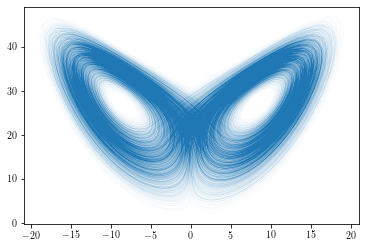

In [3]:
plt.plot(tseries[:,0],tseries[:,2],lw=.02)
plt.show()

# Compute predictability as a function of delay

In [4]:
X = tseries[:,0].reshape((tseries.shape[0],1)) #take x variable only

In [5]:
#to get error estimates in the manuscript we split the trajectory into non-overlapping segments

n_seed_range=np.arange(200,1100,200) #number of partitions to examine
range_Ks =  np.arange(1,12,dtype=int) #range of delays to study
h_K=np.zeros((len(range_Ks),len(n_seed_range)))
for k,K in enumerate(range_Ks):
    traj_matrix = embed.trajectory_matrix(X,K=K-1)
    for ks,n_seeds in enumerate(n_seed_range):
        labels=cl.kmeans_knn_partition(traj_matrix,n_seeds)
        h = op_calc.get_entropy(labels)
        h_K[k,ks]=h
        print('Computed for {} delays and {} seeds.'.format(K,n_seeds))

Computed for 1 delays and 200 seeds.
Computed for 1 delays and 400 seeds.
Computed for 1 delays and 600 seeds.
Computed for 1 delays and 800 seeds.
Computed for 1 delays and 1000 seeds.
Computed for 2 delays and 200 seeds.
Computed for 2 delays and 400 seeds.
Computed for 2 delays and 600 seeds.
Computed for 2 delays and 800 seeds.
Computed for 2 delays and 1000 seeds.
Computed for 3 delays and 200 seeds.
Computed for 3 delays and 400 seeds.
Computed for 3 delays and 600 seeds.
Computed for 3 delays and 800 seeds.
Computed for 3 delays and 1000 seeds.
Computed for 4 delays and 200 seeds.
Computed for 4 delays and 400 seeds.
Computed for 4 delays and 600 seeds.
Computed for 4 delays and 800 seeds.
Computed for 4 delays and 1000 seeds.
Computed for 5 delays and 200 seeds.
Computed for 5 delays and 400 seeds.
Computed for 5 delays and 600 seeds.
Computed for 5 delays and 800 seeds.
Computed for 5 delays and 1000 seeds.
Computed for 6 delays and 200 seeds.
Computed for 6 delays and 400 see

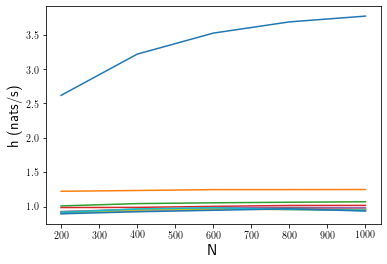

In [6]:
plt.plot(n_seed_range,h_K.T)
plt.xlabel('N',fontsize=15)
plt.ylabel('h (nats/s)',fontsize=15)
plt.show()

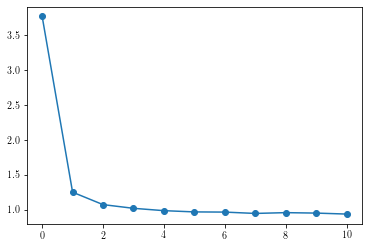

In [7]:
plt.plot(h_K[:,-1],marker='o')
plt.show()

In [8]:
K_star=6
traj_matrix = embed.trajectory_matrix(X,K=K_star-1)

# Estimate implied time scales of the reversibilized operator

In [9]:
#to get error estimates in the manuscript we split the trajectory into non-overlapping segments

n_seeds = 1000
n_modes=10
n_samples = 50 #bootstrapping samples
range_delays = np.arange(1,21)
size = 10000

labels = ma.array(cl.kmeans_knn_partition(traj_matrix,n_seeds),dtype=int)

delay_range = np.arange(1,20,1)
n_modes=5
ts_traj = np.zeros((len(delay_range),n_modes))
for kd,delay in enumerate(delay_range):
    P = op_calc.transition_matrix(labels,delay)
    R = op_calc.get_reversible_transition_matrix(P)
    ts_traj[kd,:] = op_calc.compute_tscales(R,delay,dt,k=n_modes+1)
    print(delay)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


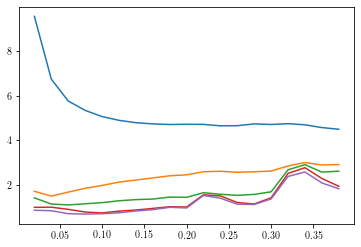

In [10]:
plt.plot(delay_range*dt,ts_traj)
plt.show()

In [11]:
delay = 12
print(delay*dt)
P = op_calc.transition_matrix(labels,delay)
R = op_calc.get_reversible_transition_matrix(P)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=3)
print(eigvals)

0.24
[1.        +0.j 0.9497372 +0.j 0.91241111+0.j]


In [12]:
X=eigvecs[:,1].real

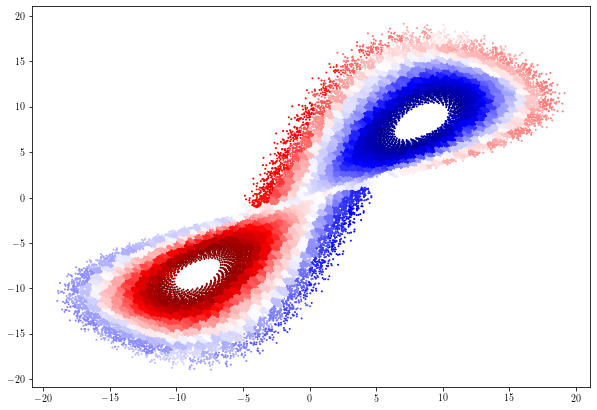

In [13]:
plt.figure(figsize=(10,7))
color_abs = np.max(np.abs(X))
plt.scatter(traj_matrix[:,0],traj_matrix[:,-1],c=X[labels],cmap='seismic',s=1,vmin=-color_abs,vmax=color_abs)
# plt.xticks(range(-20,21,5))
# plt.ticks()
# plt.savefig('Phi_2_Lorenz.png')
plt.show()